<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Doc2Vec/Doc2Vec_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Doc2Vec

**Autores**:

- Kauê Capellato J. Parreira (kauecapellatojp@gmail.com)

# Introdução

Um dos grandes desafios de algoritmos de ciência da computação é a representação numérica de textos e documentos. Neste sentido, apresentamos uma breve explicação de um modelo que é visto como uma extensão do Word2Vec, previamente descrito, denominado **Doc2Vec** ou **Paragraph Vector** - Vetor de Parágrafos.

Tal modelo foi roposto por Tomas Mikolov e Quoc Le [[1]](https://arxiv.org/pdf/1405.4053.pdf), ambos funcionários do Google na época do desenvolvimento do mesmo, em 2014.

Para a apresentação da parte teórica, utilizamos como base as referências dadas em [[2]](https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da), [[3]](https://aclanthology.org/W16-1609.pdf), [[4]](https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137) e [[5]](http://dspace.unipampa.edu.br/bitstream/riu/1601/1/An%C3%A1lise%20de%20sentimento%20usando%20a%20representa%C3%A7%C3%A3o%20distribu%C3%ADda%20de%20par%C3%A1grafos%20para%20o%20portugu%C3%AAs.pdf).

##O que é o Doc2Vec e como funciona

Como dito acima, o Doc2Vec, também chamado de $\textit{Paragraph Vector}$ (Vetor de Paragráfos), pode ser visto como uma extensão do Word2Vec no sentido de, no caso do Word2Vec, cujo objetivo é a representação de palavras no espaço real d-dimensional ($R^d$, $\,$ $d \in \textbf{Z}^{+}$), ser utilizado para a representação de documentos no espaço d-dimensional.

O Vetor de Paragráfos é um algoritmo não supervisionado que aprende representações vetoriais diferentes para as palavras de variados textos. Apesar do seu nome, ele enfatiza o fato que podemos utilizá-lo para textos de diversos tamanhos, desde simples sentenças até enormes documentos.

Agora veremos brevemente a estrutura do Vetor de Parágrafos.

## Alguns detalhes da estrutura do Doc2Vec

O Doc2Vec possui duas variações: PV-DM e DBOW, possuindo algumas semelhanças com o Word2Vec. Explicaremos brevemente como essas variações funcionam abaixo. 

### PV-DM: Paragraph Vector - Distributed Memory

Essa abordagem se assemelha ao CBOW (Continuous Bag-Of-Words) do Word2Vec, uma vez que recebe como entrada as palavras de contexto (uma vizinhança da palavra $\textit{target}$) e retorna um vetor de probabilidades da palavra pertencer àquele contexto. Porém uma diferença se torna presente: a presença de uma matriz de paragráfos (representada por D na figura abaixo), realizando o mapeamento dos paragráfos para vetores distintos de palavras.

Assim, cada parágrafo é mapeado para um único vetor, que representa uma coluna em **D** e cada palavra também é mapeada para um único vetor, que representa cada coluna em **W**. Depois disso, é feita a média ou concatenação desses vetores para a predição da próxima palavra no contexto.



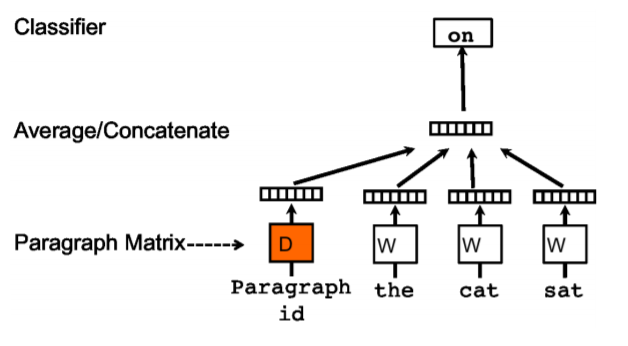

Fonte: Distributed Representations of Sentences and Documents [[1]](https://arxiv.org/pdf/1405.4053.pdf)


O token de parágrafos funciona memorizando o que está faltando do contexto e por isso o nome Distributed Memory.  

Após o treinamento, o Vetor de Parágrafos pode ser utilizado como *features* em modelos convencionais, como a Regressão Logística, CatBoost, Florestas Aleatórias, XGBoost, etc. 

Algumas vatangens dos Vetores de Parágrafos são o fato deles utilizarem dados não rotulados e fornecerem uma boa generalização para altas dimensões, preservando a semântica e a ordem das palavras. 


### PV-DBOW: Paragraph Vector - Distributed Bag-Of-Words

Essa abordagem, por sua vez, é semelhante ao Skip-Gram do Word2Vec, ou seja, no caso desse modelo, dado uma palavra, o objetivo é prever o contexto. No DBOW, é utilizado o Vetor de Paragráfos para prever as palavras de um determinado texto ou uma amostra desse texto.

E também pode ser visto como o modelo acima, sendo que os vetores de palavras **W** são ignorados durante o processo de treinamento e o modleo é forçado a prever palavras escolhidas aleatoriamente do parágrafo.



A imagem abaixo representa um esquema simplificado de como PV-DBOW atua.

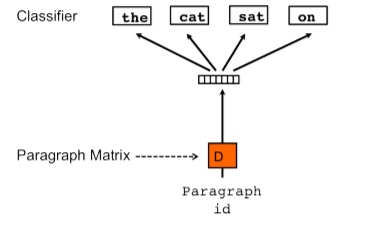

Fonte: Distributed Representations of Sentences and Documents [[1]](https://arxiv.org/pdf/1405.4053.pdf)


Como vantagem, essa abordagem requere menos armazenamento, sendo assim mais eficiente, uma vez que os vetores de palavras são ignorados.

#Mão na massa

Agora vamos ver uma aplicação do Doc2Vec em uma tarefa de classificação com um conjunto de dados de textos jurídicos com seus status: Ativo, Suspenso ou Arquivado. Comecemos com a parte brevemente descritiva e de pré-processamento dos dados. 

##Importando

Vamos importar as bibliotecas necessárias para a utilização do modelo.

##Importando

Vamos importar as bibliotecas necessárias para a utilização do modelo.

In [1]:
# inicializando a seed e importando algumas bibliotecas
random_seed=42

import numpy as np
import random
import os

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(random_seed)
random.seed(random_seed)

In [2]:
from IPython.display import clear_output
!pip install ftfy
!pip install gensim=='3.8.3'
!pip install git+https://github.com/legalnlp21/legalnlp
clear_output()

In [3]:
import re
import ftfy
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from legalnlp.clean_functions import *

Célula de comando para fazer o download do modelo Doc2Vec pré-treinado.

In [4]:
from legalnlp.get_premodel import *
get_premodel('wodc')

True

Aqui vamos importar o conjunto de dados no qual iremos trabalhar neste tutorial:

In [5]:
data=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

E uma breve visualização desses dados:

In [6]:
data.head()

,text,label
0,Início da Execução Juntado 0008003-11.2018.8.2...,H:Suspenso
1,Ofício Requisitório - Comunicação - Protocolo ...,H:Arquivado
2,Arquivado Provisoriamente aguardando manifestação,H:Suspenso
3,Petição Juntada Juntada a petição diversa - Ti...,H:Ativo
4,Remetidos os Autos para o Arquivo Geral – Devo...,H:Arquivado


Esse conjunto de dados possui 6449 observações e 2 variáveis.

Vamos ver agora se temos dados faltantes:

In [7]:
print("Quantidade de dados faltantes: ", data.isna().any().sum())

Quantidade de dados faltantes:  0


Isso é bom.Não temos nenhum dado faltante! Porém, vemos que os dados precisam ser limpos antes de serem aplicados no modelo, então vamos aplicar um função que limpa essas observações da coluna $text$.

Aplicamos então a função de limpeza na coluna $text$:

In [8]:
data['text'] = data['text'].apply(lambda x: clean(x))

E obtemos os dados agora limpos, vamos dar uma olhada:

In [9]:
str(data.loc[1,'text'])

'ofício requisitório - - comunicação - - protocolo eletrônico - - depre'

## Carregando o Modelo

Agora vamos carregar o modelo Doc2Vec pré-treinado, com abordagem PV-DBOW, de tamanho: $size = 100$ e tamanho de janela: $window\_size = 15$.

In [10]:
model = Doc2Vec.load('/content/W2V_D2V/w2v_d2v_dbow_size_100_window_15_epochs_20')

Com o modelo carregado, podemos utilizar alguns métodos fornecidos na documentação da biblioteca [Gensim](https://radimrehurek.com/gensim/models/doc2vec.html) para o Doc2Vec.

Com o modelo pré-treinado, podemos inferir novos vetores para novas senteças. 

In [11]:
model.infer_vector(["textos", "juridicos"])

array([-0.1030191 , -0.05632177, -0.02111034, -0.01477912,  0.08859691,
        0.02618328,  0.00470686,  0.02067146,  0.07080251, -0.01030859,
        0.02328557, -0.09443733,  0.02825467,  0.10289488,  0.01307181,
       -0.04317994, -0.00096141, -0.01497693,  0.0938751 , -0.02948976,
       -0.09346696,  0.10721117, -0.09840091,  0.01705137,  0.0280817 ,
       -0.0404134 ,  0.00554621,  0.09120063,  0.04183859,  0.13037364,
       -0.03509588,  0.11194015, -0.0080341 , -0.09664524, -0.11105052,
       -0.04217411, -0.05154098, -0.09840264, -0.01711421,  0.03977254,
       -0.03594672, -0.00671438,  0.03774045, -0.00623902, -0.02161633,
        0.08910725, -0.17854863, -0.00246937,  0.02278156, -0.21726751,
       -0.08289417, -0.04753321, -0.04860727,  0.02490096, -0.00717204,
       -0.04692703,  0.02372213,  0.11139277, -0.05384314, -0.02496658,
        0.08433156,  0.00713941,  0.02046285,  0.05751709,  0.06482287,
       -0.0220664 , -0.03516502, -0.04055115,  0.04357478,  0.00

In [12]:
model.wv.similar_by_word("banco")

[('brasil', 0.7986418008804321),
 ('banco_itaú', 0.6769572496414185),
 ('banco_mercantil', 0.6748969554901123),
 ('bradesco', 0.665328860282898),
 ('banrisul', 0.6483218669891357),
 ('banco_santander', 0.6408952474594116),
 ('santander', 0.6307247877120972),
 ('agência', 0.6243692636489868),
 ('bnb', 0.6186673641204834),
 ('caixa_econômica_federal', 0.604042112827301)]

##De textos para vetores

Primeiramente vamos transformar as $labels$ aplicando o LabelEncoder da biblioteca sklearn.

In [13]:
encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(encoder.fit_transform(data['label']))
data.loc[[0, 1, 5]]

,text,label,encoded
0,início da execução juntado [processo] - - cump...,H:Suspenso,2
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0
5,petição juntada nº protocolo : wscb [numero] t...,H:Arquivado,0


Agora vamos inferir os textos para obter vetores.

In [14]:
from tqdm import tqdm

In [15]:
def vetor_inferido(texto):

  string = str(texto).split()

  model.random.seed(random_seed)
  inferido = model.infer_vector(string, steps = 100)
  
  vetores = np.array(inferido)

  return vetores

In [16]:
data['infered'] = data['text'].apply(lambda x: vetor_inferido(x))

In [17]:
data.head(5)

,text,label,encoded,infered
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.52983445, -0.21708997, -0.29276618, 0.02952..."
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.15962815, -0.08503195, -0.1870227, 0.14198..."
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.5544537, -0.36946914, -0.00600129, -0.3623..."
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.096351445, -0.038573958, -0.6030474, 0.7731..."
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[0.08174139, -0.50010914, 0.3102109, -0.133682..."


In [18]:
for i in range(0, 100):
  data[str(i)] = np.vstack(data.loc[:, 'infered'])[:, i]

In [19]:
data.head(5)

,text,label,encoded,infered,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.52983445, -0.21708997, -0.29276618, 0.02952...",0.529834,-0.217090,-0.292766,0.029526,0.014033,-0.197360,-0.292294,0.320754,-0.074080,0.642625,-0.017845,0.165787,-0.045661,0.127698,0.133882,0.630716,-0.205818,0.121968,0.559631,-0.368258,-0.325892,0.099700,-0.848190,-0.029574,-0.308272,-0.339307,-0.533801,0.158608,-0.279163,0.283171,0.576813,0.136127,-0.097371,-0.128804,-0.002125,-0.272275,...,-0.085178,0.562758,-0.530687,-0.115071,0.318222,-0.246560,-0.407256,-0.028620,-0.294833,-0.240463,0.532746,0.141088,-0.190935,0.229553,-0.398385,-0.301532,0.016245,-0.028941,-0.184342,0.186794,0.248229,0.572594,0.319560,-0.474347,-0.248480,0.436949,-0.455782,0.050308,0.312872,-0.002886,-0.452171,0.160058,0.178896,-0.101638,0.519232,0.121950,0.085590,0.329147,-0.339280,-0.241162
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.15962815, -0.08503195, -0.1870227, 0.14198...",-0.159628,-0.085032,-0.187023,0.141981,-0.203657,-0.501000,-0.381098,0.628261,0.339412,0.083989,0.311307,0.344663,0.881265,0.133534,0.359802,-0.034032,0.496789,0.129232,0.552131,-0.042910,0.093072,-0.099297,-0.893716,0.216858,-0.104052,-0.045242,-0.588823,0.567432,0.270987,0.200220,0.023054,0.082693,-0.336874,-0.414352,-0.224484,-0.474769,...,0.055712,0.037901,-0.386322,-0.082055,-0.343568,-0.335805,-0.123151,-0.495131,-0.804753,0.082980,0.148255,-0.385675,-0.306221,0.509968,-0.478291,-0.322404,-0.121873,-0.208746,-0.426891,0.339243,0.066621,0.689973,0.291032,0.119312,-0.043589,0.154622,-0.480139,0.303168,-0.295673,-0.066605,-0.206266,0.335755,-0.633886,-0.406231,0.374564,-0.173605,-0.001893,0.186168,0.193314,-0.646927
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.5544537, -0.36946914, -0.00600129, -0.3623...",-0.554454,-0.369469,-0.006001,-0.362384,0.468038,0.351987,-0.332980,0.265272,0.172875,0.065480,-0.044783,-0.299451,0.128792,-0.168730,0.010698,0.486061,-0.710522,0.283538,0.844245,0.036938,-0.070465,0.145250,-0.535092,0.039594,0.302926,-0.090326,-0.163483,-0.372941,0.212592,0.118683,0.104354,-0.007665,-0.401533,0.082410,0.016091,0.283348,...,0.052942,-0.054539,-0.478694,-0.204724,0.191574,-0.204516,-0.431096,0.004109,-0.526067,-0.158970,0.186463,-0.133687,-0.199880,-0.570701,-0.400945,0.247073,-0.198944,-0.132808,-0.564654,0.013618,-0.268086,0.451895,0.417725,-0.000454,-0.157520,0.016551,-0.323526,0.157791,-0.241297,-0.371213,-0.373450,-0.425790,-0.637790,-0.190985,0.534808,0.296304,0.217366,-0.018066,-0.046994,-0.532406
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.096351445, -0.038573958, -0.6030474, 0.7731...",0.096351,-0.038574,-0.603047,0.773195,-1.101300,-0.304274,-0.136263,0.308297,-0.670536,-0.038493,0.459891,0.745955,0.422733,1.190531,0.709394,-0.631514,0.751086,0.790955,1.075292,0.054508,0.201271,0.255086,-0.899003,0.324058,-0.354325,0.184531,-0.940772,0.317172,-0.012310,0.759822,-0.066940,0.202122,-0.849952,-0.017878,-0.210681,0.359964,...,0.193831,-0.385065,-0.070323,-0.500060,-0.708193,-0.213873,-0.347498,0.466096,-0.136102,-0.839362,0.573390,0.574075,-0.267528,0.706798,0.158277,0.538030,-0.428186,-0.142621,-0.365399,-0.135466,-0.347945,1.133555,0.508619,0.326276,0.163862,-0.020152,0.057465,-0.408833,-0.497116,-0.130817,-0.147835,0.014915,0.229293,-0.278487,0.213153,-0.146858,0.177391,0.145507,0.086815,-1.463906
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[0.08174139, -0.50010914, 0.3102109, -0.133682...",0.081741,-0.500109,0.310211,-0.133682,0.418879,0.214079,0.198273,0.428277,-0.080590,-0.412623,0.335069,-0.189216,0.010074,0.365830,0.048094,0.464792,-0.230644,0.486977,0.314145,-0.246380,-0.022640,0.716440,-0.840301,0.295952,0.043192,0.056158,0.337806

### Dados de Treino e Teste

In [20]:
X_train, X_test, y_train, y_test = train_test_split( data.drop(columns = ['encoded', 'text', 'label', 'infered']), data['encoded'], random_state = random_seed, test_size = 0.3)

In [21]:
# Tamanhos dos x e y de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4514, 100)
(1935, 100)
(4514,)
(1935,)


#Classificação


In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
def bootstrap(X_test, y_test, model, nn=False, B=250):

    #Criando um dicionário para armezenar os resultados
    out={}
    out['accuracy']=[]
    out['macro avg']={}
    out['macro avg']['f1-score']=[]
    out['macro avg']['recall']=[]
    out['macro avg']['precision']=[]
    out['weighted avg']={}
    out['weighted avg']['f1-score']=[]
    out['weighted avg']['recall']=[]
    out['weighted avg']['precision']=[]

    #Aplicando Bootstrap nos dados de teste
    for b in tqdm(range(B)):
        ind = np.random.choice(range(y_test.shape[0]),y_test.shape[0])
        X_test_boot, y_test_boot = X_test[ind,:], y_test[ind]

        y_pred=model.predict(X_test_boot)
        
        if nn:
            y_pred=np.argmax(y_pred,axis=1)
            report=classification_report(y_test_boot, y_pred, labels=[0, 1, 2], output_dict=True)
        else:
            report=classification_report(y_test_boot, y_pred, labels=[0, 1, 2], output_dict=True)

        out['accuracy'].append(report['accuracy'])
        out['macro avg']['f1-score'].append(report['macro avg']['f1-score'])
        out['macro avg']['recall'].append(report['macro avg']['recall'])
        out['macro avg']['precision'].append(report['macro avg']['precision'])
        out['weighted avg']['f1-score'].append(report['weighted avg']['f1-score'])
        out['weighted avg']['recall'].append(report['weighted avg']['recall'])
        out['weighted avg']['precision'].append(report['weighted avg']['precision'])

    #Preparando a saída
    y_pred=model.predict(X_test)
    
    if nn:
        y_pred=np.argmax(y_pred,axis=1)
        report=classification_report(y_test, y_pred, labels=[0, 1, 2], output_dict=True)
    else:
        report=classification_report(y_test, y_pred, labels=[0, 1, 2], output_dict=True)

    out['accuracy'] = [report['accuracy'], np.std(out['accuracy'])]
    out['macro avg']['f1-score'] = [report['macro avg']['f1-score'], np.std(out['macro avg']['f1-score'])] 
    out['macro avg']['recall'] = [report['macro avg']['recall'], np.std(out['macro avg']['recall'])] 
    out['macro avg']['precision'] = [report['macro avg']['precision'], np.std(out['macro avg']['precision'])] 
    out['weighted avg']['f1-score'] = [report['weighted avg']['f1-score'], np.std(out['weighted avg']['f1-score'])] 
    out['weighted avg']['recall'] = [report['weighted avg']['recall'], np.std(out['weighted avg']['recall'])] 
    out['weighted avg']['precision'] = [report['weighted avg']['precision'], np.std(out['weighted avg']['precision'])]
    
    return out

##CatBoost - Categorical Boost

Aqui vamos aplicar um modelo chamado CatBoost (Categorical Boosting), que é um modelo de aprendizado por comitê (ensemble learning).

In [24]:
!pip install catboost
clear_output()

In [25]:
# Importando o CatBoostClassifier 
from catboost import CatBoostClassifier

In [26]:
# creating validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state = random_seed)

In [27]:
tunned_model = CatBoostClassifier(
    loss_function = 'MultiClass',
    random_seed=random_seed,
)

tunned_model.fit(
    X_train, y_train,
    verbose=500,
    eval_set=(X_val, y_val),
    early_stopping_rounds = 100
)

Learning rate set to 0.111046
0:	learn: 0.9913229	test: 0.9902410	best: 0.9902410 (0)	total: 155ms	remaining: 2m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3939352979
bestIteration = 297

Shrink model to first 298 iterations.


In [28]:
y_cat_pred = tunned_model.predict(X_test)

In [29]:
print("A acurácia do modelo é de: ", accuracy_score(y_test, y_cat_pred))

A acurácia do modelo é de:  0.8532299741602067


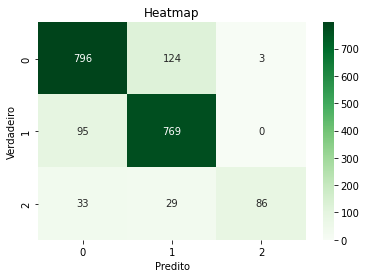

In [30]:
cm = confusion_matrix(y_test, y_cat_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [31]:
print(classification_report(y_test, y_cat_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       923
           1       0.83      0.89      0.86       864
           2       0.97      0.58      0.73       148

    accuracy                           0.85      1935
   macro avg       0.89      0.78      0.82      1935
weighted avg       0.86      0.85      0.85      1935



In [32]:
report_boot=bootstrap(np.array(X_test), np.array(y_test), tunned_model)

for i in ['accuracy', 'macro avg', 'weighted avg']:
 if i == 'accuracy':
     print("\n\n{:27}: {:.2f} ± {:.2f}".format(i, report_boot[i][0], report_boot[i][1]))
 for j in ['f1-score', 'recall', 'precision']:
   if i != 'accuracy':
     print("{:15}  {:10}: {:.2f} ± {:.2f}".format(i, j, report_boot[i][j][0], report_boot[i][j][1]))

100%|██████████| 250/250 [00:04<00:00, 60.78it/s]



accuracy                   : 0.85 ± 0.01
macro avg        f1-score  : 0.82 ± 0.01
macro avg        recall    : 0.78 ± 0.01
macro avg        precision : 0.89 ± 0.01
weighted avg     f1-score  : 0.85 ± 0.01
weighted avg     recall    : 0.85 ± 0.01
weighted avg     precision : 0.86 ± 0.01


#Referências

[1] Mikolov, T., Le, Quoc (2014).  Distributed Representations of Sentences and Documents. arXiv:1405.4053v2. \\


[2] Amar Budhiraja (2018) https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da. Acesso em: 04/08/2021. \\

[3] Lau H. J., Baldwin T. An Empirical Evaluation of doc2vec with
Practical Insights into Document Embedding Generation. aclanthology: W16-1609. \\

[4] Abhinav Roy (2020) https://heartbeat.fritz.ai/getting-started-with-doc2vec-2645e3e9f137. Acesso em: 04/04/2021. \\

[5] Araujo S. Filipe. Análise de Sentimento usando a Representação
Distribuída de Parágrafos para o Português. Universidade Federal do Pampa.
